In [1]:
import pickle

import numpyro
import numpyro.handlers as handlers
import jax.numpy as jnp
import jax
from numpyro.infer import Predictive

from src.models.M2VAE import M2VAE
from src.models.encoder_decoder import MNISTEncoder, MNISTDecoder, CIFAR10Encoder, CIFAR10Decoder
from src.data_loading.loaders import get_data_loaders

import matplotlib.pyplot as plt

c:\Users\Matthieu Dinot\Desktop\MVA\PGM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
# Set up random seed
seed = 42

# DATASET
dataset_name = "MNIST" # use "CIFAR10"

encoder_class = MNISTEncoder if dataset_name=="MNIST" else CIFAR10Encoder
decoder_class = MNISTDecoder if dataset_name=="MNIST" else CIFAR10Decoder
distribution = "bernoulli" if dataset_name=="MNIST" else "laplace"

In [47]:
img_shape, loader_dict, size_dict = get_data_loaders(dataset_name=dataset_name, 
                                          p_test=0.2, 
                                          p_val=0.2, 
                                          p_supervised=0.05, 
                                          batch_size=10, 
                                          num_workers=0, 
                                          seed=seed)

scale_factor = 1.

Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 12000
Num validation samples: 9600
Num supervised samples: 1920
Num unsupervised samples: 36480


In [48]:
m2_vae = M2VAE(encoder_class, 
               decoder_class, 
               10, 
               50, 
               img_shape, 
               scale_factor=scale_factor, 
               distribution=distribution
)

In [49]:
with open("./model_weights/m2" + dataset_name + ".pkl", 'rb') as file:
    params=pickle.load(file)

In [66]:
xs = jnp.zeros((10,) + img_shape)
ys = jnp.array([i for i in range(10)])

"""
# OR 
load = iter(loader_dict["test"])
xs, ys = next(load)

n_rows = 2
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        image = xs[i * n_cols + j]
        
        if dataset_name == "MNIST":
            image = image.squeeze(-1)
            plt.imshow(image, cmap='gray')
        elif dataset_name == "CIFAR10":
            plt.imshow(image)
        plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()"""


'\n# OR \nload = iter(loader_dict["test"])\nxs, ys = next(load)\n\nn_rows = 2\nn_cols = 5\n\nplt.figure(figsize=(n_cols * 2, n_rows * 2))\nfor i in range(n_rows):\n    for j in range(n_cols):\n        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)\n        image = xs[i * n_cols + j]\n        \n        if dataset_name == "MNIST":\n            image = image.squeeze(-1)\n            plt.imshow(image, cmap=\'gray\')\n        elif dataset_name == "CIFAR10":\n            plt.imshow(image)\n        plt.axis(\'off\')  # Turn off the axis labels\n\n# Adjust layout and show the plot\nplt.tight_layout()\nplt.show()'

In [67]:
print(xs.shape, ys.shape)

(10, 28, 28, 1) (10,)


In [68]:
predictive = Predictive(m2_vae.model_supervised, params=params, num_samples=25 ,return_sites=["loc"])

rng_key = jax.random.PRNGKey(0) 
predictions = predictive(rng_key, xs, ys)

loc = predictions['loc']

print(loc.shape)

(25, 10, 28, 28, 1)


In [71]:
class_number = 5

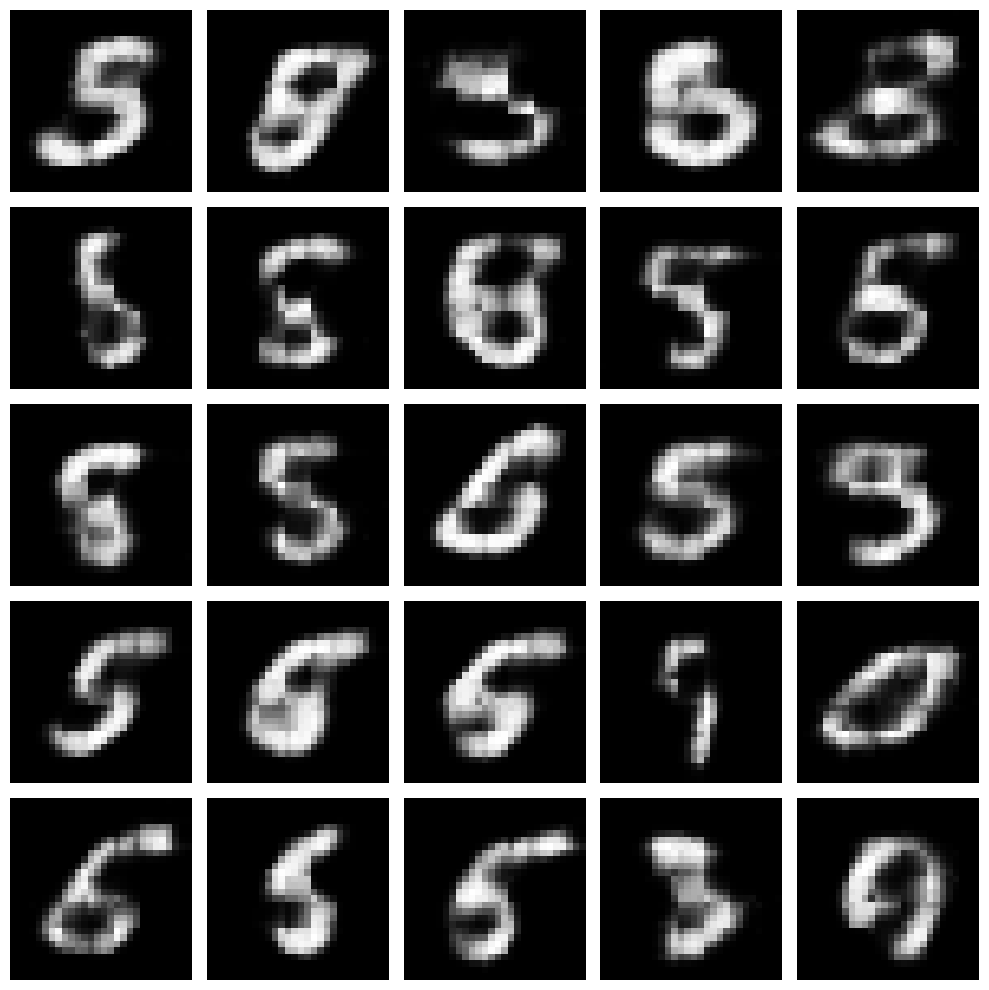

In [72]:
n_rows = 5
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = loc[i, class_number]

    if dataset_name == "MNIST":
        image = image.squeeze(-1)
        plt.imshow(image, cmap='gray')
    elif dataset_name == "CIFAR10":
        plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()